# Gelu Activation Function

In [1]:
import torch
from torch import nn
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

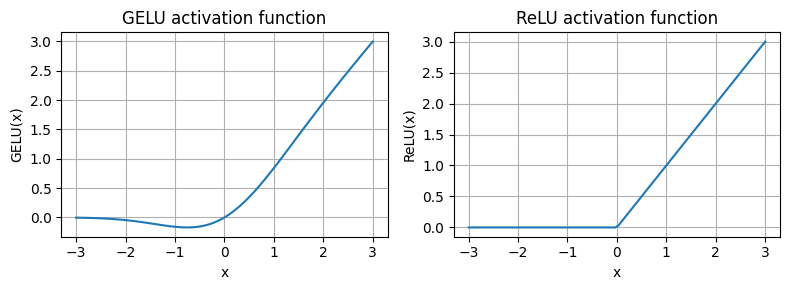

In [2]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100) # creates 100 sample data points in the range -3 to 3
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8,3))

for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1,2,i)
    plt.plot(x,y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        )
    def forward(self, x):
        return self.layers(x)

In [18]:

GPT_CONFIG_124M = {
    "vocab_size": 50257,  # Vocabulary size used by BPE tokenizer
    "context_length": 1024, # max numbers of vocabulary the token can handle via positional embeddings
    "emb_dim": 768, # embedding size for each vocab
    "n_heads": 12, # count of attention heads in multi-head attention mechanism
    "n_layers": 12, # 
    "drop_rate": 0.1, # intensity dropout mechanism, 0.1 means 10% to prevent overfittin g
    "qkv_bias": False # we initially disable this
}

In [28]:
import tiktoken 

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)

In [19]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


In [20]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU()),
        ])
    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output 
            else:
                x = layer_output 
        return x


In [21]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)

In [22]:
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target)

    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [23]:
# without shortcut
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041071094573
layers.3.0.weight has gradient mean of 0.0013988735154271126
layers.4.0.weight has gradient mean of 0.005049645435065031


In [24]:
# using shortcut connections
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


In [25]:
# we import MultiHeadAttention from chapter 3
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out  // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )
    def forward(self, x):
        print(self.W_key)
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        # We add a 'num_heads' dimension
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # transpose from shape (b, num_tokens, num_heads, head_dim) to (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1] ** 0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @  values).transpose(1, 2)
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec
    
# and we need LayerNormalization
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        # scale and shift is a trainable parameters, LLM automatically adjust it
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift
        

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads = cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    def forward(self,x ):
        shortcut = x 
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut 

        shortcut = x 
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut 

        return x


In [30]:

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape 
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds 
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


In [31]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("input batch: \n", batch)
print("\noutput shape:", out.shape)
print(out)

Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_features=768, bias=False)
input batch: 
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4223, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0

In [32]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [33]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape torch.Size([50257, 768])


In [37]:
total_params_gpt2 = (
    total_params - sum(p.numel() for p in model.out_head.parameters())
)
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


# Computing memory requirements

In [38]:
total_size_bytes = total_params * 4 # float32 is 4 bytes per parameter
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


In [39]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [40]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [41]:
model.eval() # activate evaluation mode, disables random components like dropout that only used during training
out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("output length: ", len(out[0]))

Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=768, out_

In [42]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue
